In [4]:
import pandas_gbq as pbq
import pandas as pd
import warnings
import numpy as np
from datetime import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import base64
from pathlib import Path
import warnings

from appscript import app, k
from mactypes import Alias
from pathlib import Path


font_style = 'Helvetica'
    
mpl.rcParams['font.family'] = font_style
mpl.rcParams["font.weight"] = "bold"
mpl.rcParams["axes.labelweight"] = "bold"
mpl.rcParams["axes.titleweight"] = "bold"

try:
    plt.style.use(r'C:\Users\KamilcS\OneDrive - Universal Music Group\projects\matplotlibrc')
except:
    plt.style.use('/Users/KamilcS/Library/CloudStorage/OneDrive-UniversalMusicGroup/projects/matplotlibrc')

warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

palette = json.loads(open("../palette.json").read())
report_date = datetime.now().strftime('%Y-%m-%d')


# CHRIS TOMLIN
# Emmanuel: Christmas Songs of Worship (Deluxe)
# 9075957 6041
#

In [5]:
# read album JSON dict
album_dict = json.loads(open('/Users/KamilcS/Library/CloudStorage/OneDrive-UniversalMusicGroup/projects/ALBUM_DATA.json').read())

# store copy of said JSON to local repo
with open("./ALBUM_DATA.json", "w") as outfile:
    json.dump(album_dict, outfile)

# album_dict

In [6]:
def pull_down_data(albums_dict, year):
    query = open('./queries/w1_album_consumption_tracks_list.sql').read()

    dfs_list = []

    for k,v in albums_dict.items():
        master_album = k
        r2_project_number = v['r2_project_number']
        tracks_list = tuple(v['track_list'])

        query_formatted = query.format(
            r2_project_number= r2_project_number,
            tracks_list = tracks_list,
            start_date = f'{year}-10-01',
            end_date = f'{year}-12-31'
        )

        print(f'pulling: {master_album}\t {year}')

        df = pbq.read_gbq(query_formatted, project_id='umg-us')
        df['transaction_date'] = pd.to_datetime(df['transaction_date'])
        df['master_album'] = master_album
        dfs_list.append(df)

    
    # AFTER LOOP IS DONE, DO BELOW

    df = pd.concat(dfs_list)

    df['album_adjusted_units'] = np.where(
        df['usage_group'].str.contains('Streaming (Premium)', regex=False), df['units'].div(1250), 
            np.where(df['usage_group'].str.contains('Streaming (Free)', regex=False), df['units'].div(3750),
                np.where(
                    df['product_type'].str.contains('Video', regex=False), df['units'].div(3750),
                        np.where(
                            df['usage_group'].str.contains('Download (Track)', regex=False), df['units'].div(10), df['units']
                        )
                    )
                )
            )

    df['raw_stream_units'] = np.where(
        df['usage_group'].str.contains('Streaming', regex=False), df['units'], 0
    )


    df['product_type'] = np.where(
        df['product_type'] == 'Track', 'Audio', df['product_type']

    )

    # Small accounts as Others
    big_accounts = df.groupby('account').album_adjusted_units.sum()[df.groupby('account').album_adjusted_units.sum() > 1000].index
    df['account'] = np.where(
        df['account'].isin(big_accounts), df['account'], 'Others'
    )

    # US and XUS distinction
    df['sales_country_name'] = np.where(
        df['sales_country_name'] == 'United States', 'US', 'XUS'
    )

    df['year'] = df['transaction_date'].dt.year
    df['month'] = df['transaction_date'].dt.month
    df['day'] = df['transaction_date'].dt.day
    df['month_day'] = df['transaction_date'].dt.strftime('%b-%d')
    

    # FIX FOR AMY GRANT ALBUM, STRAND APOSTROPHES
    df['master_track'] = df['master_track'].str.replace("’", "'")


    df.rename(columns={'sales_country_name': 'country'}, inplace=True)





    return df


### KEEP FOR GENRATING
######################
years_list = [2019, 2020, 2021, 2022]
df = pd.concat([pull_down_data(album_dict['Chris Tomlin'], year) for year in years_list])
df.to_pickle('./data/chris_tomlin_christmas_albums.pkl')
######################
### KEEP FOR GENRATING

# df = pd.read_pickle('./data/chris_tomlin_christmas_albums.pkl')
# df = pd.read_pickle('./data/amy_grant_christmas_albums.pkl')

# df['master_album'] = df['master_album'].str.replace('Glory In The Highest: Christmas Songs Or Whorship', 'Glory In The Highest: Christmas Songs Or Worship')

# df = df[(df.units != 0) & (df.account != 'recochoku')]
# _2019 = pd.date_range('2019-10-01', '2019-12-31').to_series()
# _2020 = pd.date_range('2020-10-01', '2020-12-31').to_series()
# _2021 = pd.date_range('2021-10-01', '2021-12-31').to_series()
# _2022 = pd.date_range('2022-10-01', '2022-12-31').to_series()
# reindex_dates = pd.concat([_2019, _2020, _2021, _2022])

pulling: Emmanuel: Christmas Songs Of Worship	 2019


Downloading: 0rows [00:00, ?rows/s]


pulling: Miracle Of Love: Christmas Songs Of Worship	 2019


Downloading: 0rows [00:00, ?rows/s]


pulling: Adore: Christmas Songs Of Worship	 2019


Downloading: 100%|██████████| 265714/265714 [00:25<00:00, 10331.02rows/s]


pulling: Glory In The Highest: Christmas Songs Or Worship	 2019


Downloading: 100%|██████████| 133137/133137 [00:11<00:00, 11559.34rows/s]


pulling: Emmanuel: Christmas Songs Of Worship	 2020


Downloading: 0rows [00:00, ?rows/s]


pulling: Miracle Of Love: Christmas Songs Of Worship	 2020


Downloading: 100%|██████████| 53204/53204 [00:03<00:00, 14705.87rows/s]


pulling: Adore: Christmas Songs Of Worship	 2020


Downloading: 100%|██████████| 243416/243416 [00:19<00:00, 12627.39rows/s]


pulling: Glory In The Highest: Christmas Songs Or Worship	 2020


Downloading: 100%|██████████| 118711/118711 [00:08<00:00, 13327.68rows/s]


pulling: Emmanuel: Christmas Songs Of Worship	 2021


Downloading: 100%|██████████| 218606/218606 [00:16<00:00, 13350.75rows/s]


pulling: Miracle Of Love: Christmas Songs Of Worship	 2021


Downloading: 100%|██████████| 45996/45996 [00:03<00:00, 12982.11rows/s]


pulling: Adore: Christmas Songs Of Worship	 2021


Downloading: 100%|██████████| 249866/249866 [00:18<00:00, 13551.21rows/s]


pulling: Glory In The Highest: Christmas Songs Or Worship	 2021


Downloading: 100%|██████████| 142228/142228 [00:09<00:00, 14409.46rows/s]


pulling: Emmanuel: Christmas Songs Of Worship	 2022


Downloading: 100%|██████████| 202003/202003 [00:15<00:00, 13091.37rows/s]


pulling: Miracle Of Love: Christmas Songs Of Worship	 2022


Downloading: 100%|██████████| 40538/40538 [00:03<00:00, 11511.21rows/s]


pulling: Adore: Christmas Songs Of Worship	 2022


Downloading: 100%|██████████| 235076/235076 [00:17<00:00, 13441.03rows/s]


pulling: Glory In The Highest: Christmas Songs Or Worship	 2022


Downloading: 100%|██████████| 150582/150582 [00:11<00:00, 12619.57rows/s]


In [110]:
# df['master_album'] = df['master_album'].str.replace('Glory In The Highest: Christmas Songs Or Whorship', 'Glory In The Highest: Christmas Songs Or Worship')

# big_accounts = df.groupby('account').album_adjusted_units.sum()[df.groupby('account').album_adjusted_units.sum() > 1000].index


# df['account'] = np.where(
#     df['account'].isin(big_accounts), df['account'], 'Others'
# )
# df.rename(columns={'sales_country_name': 'country'}, inplace=True)

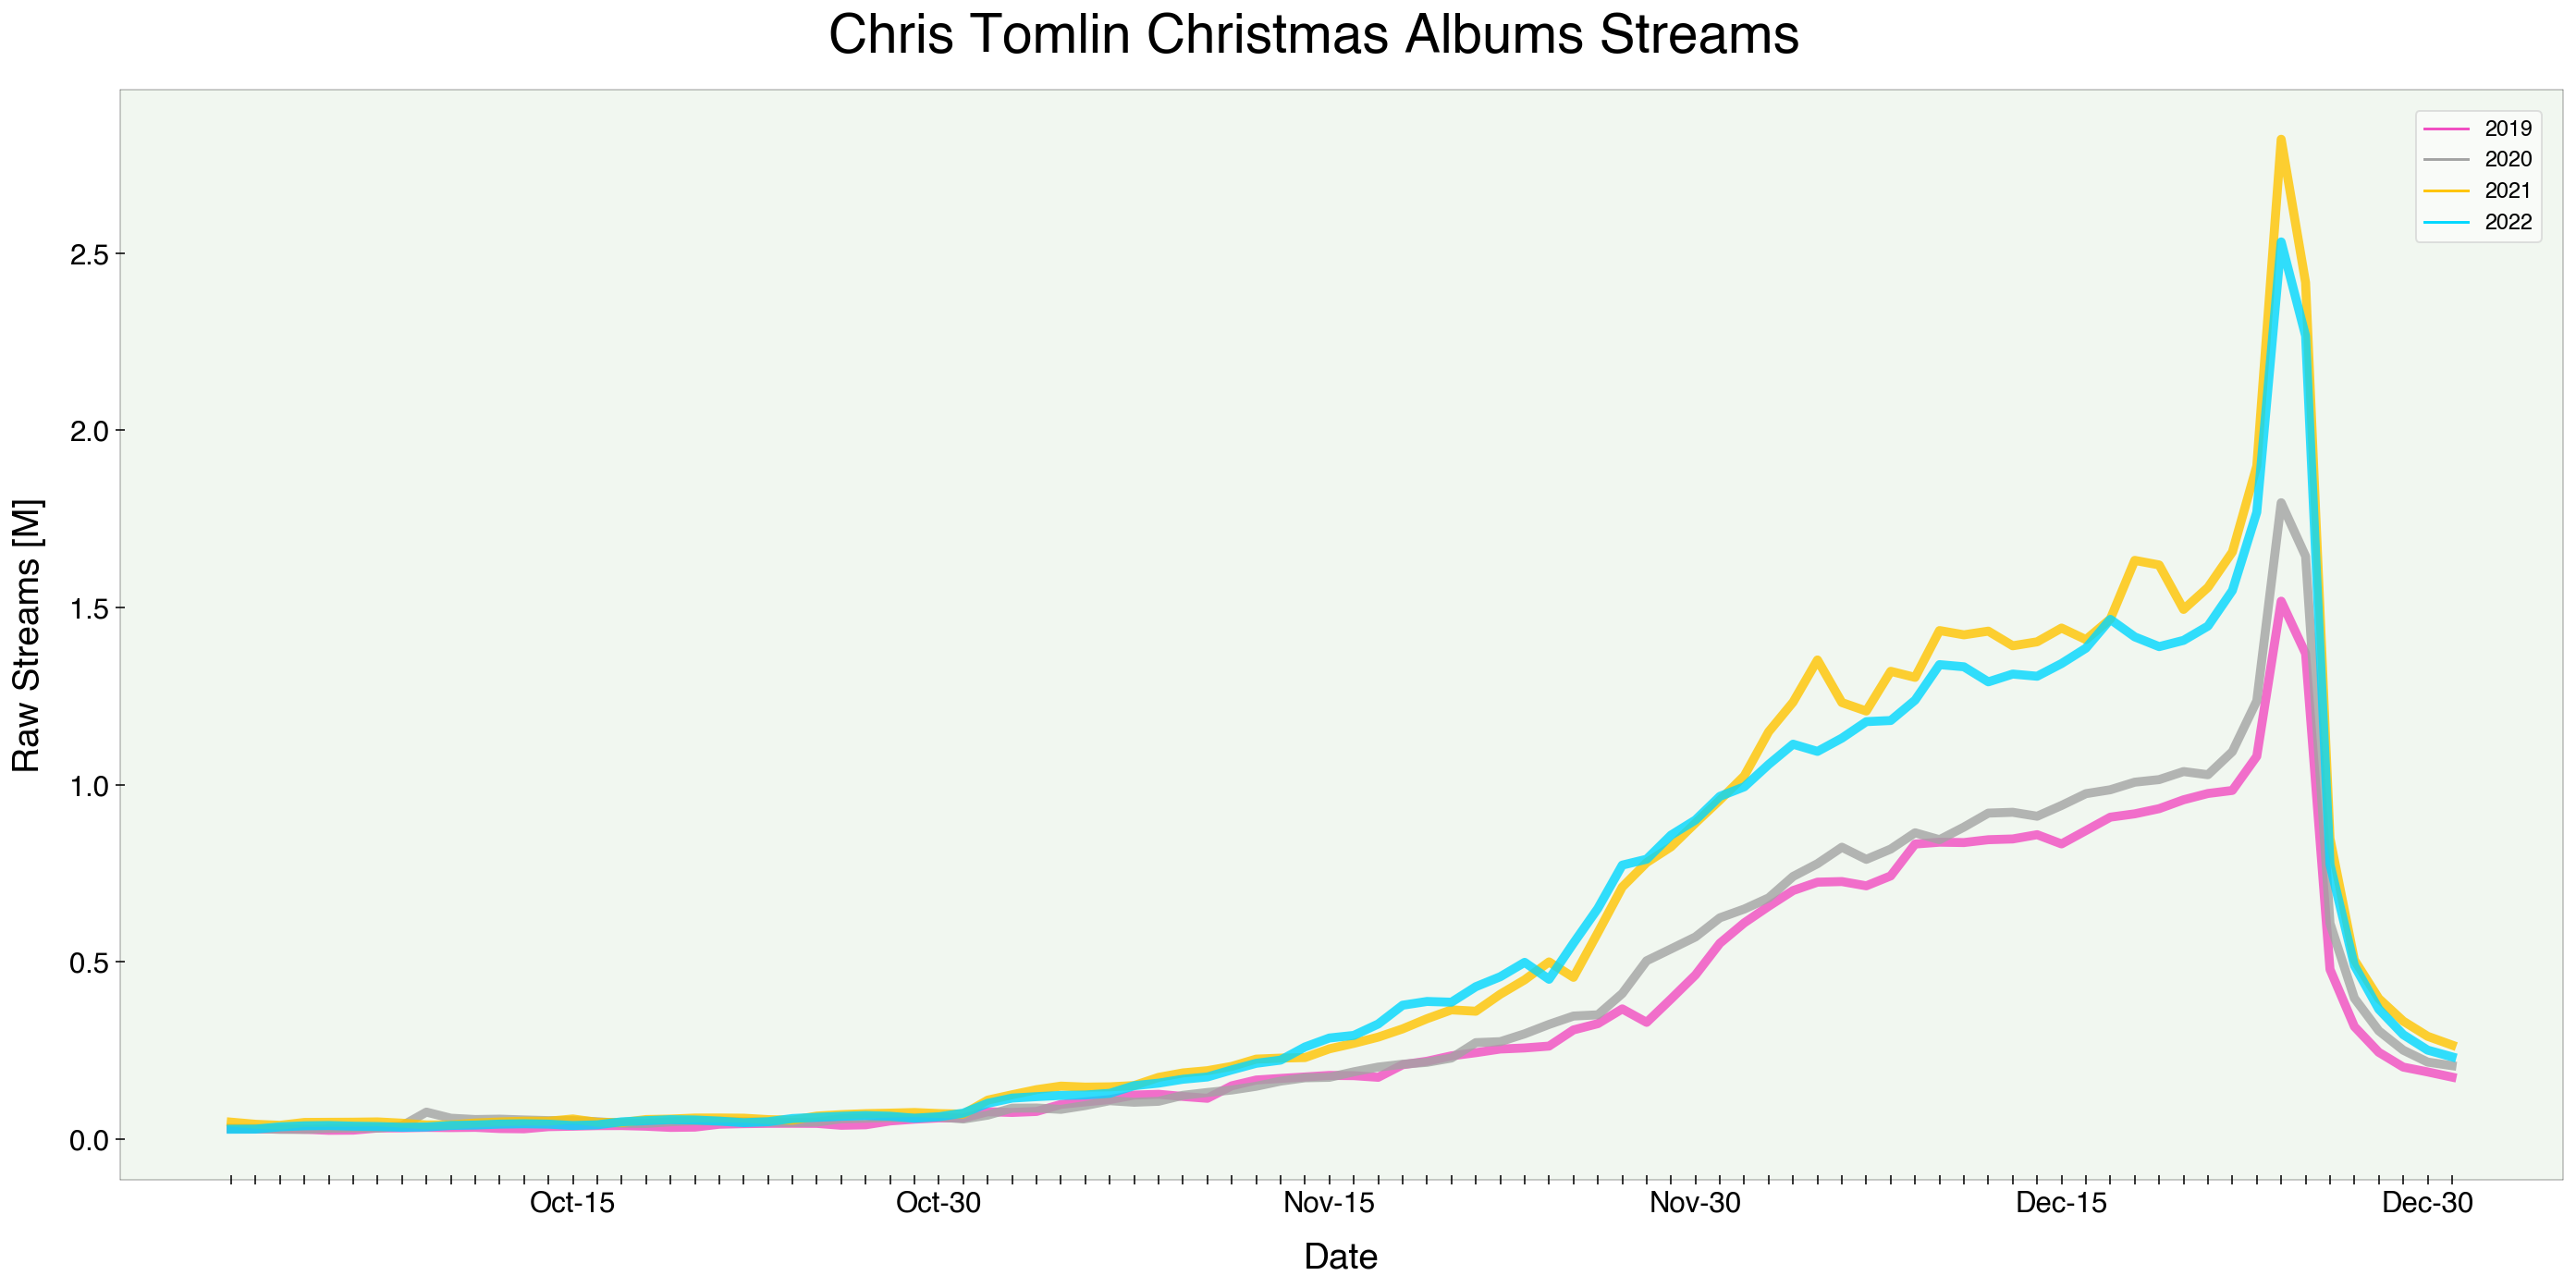

In [179]:

def plot_executive(df):
    fig, ax = plt.subplots(nrows=1,ncols=1,figsize = (20,10), dpi=140)
    title_string = f'{df.master_artist.unique()[0]} Christmas Albums Streams'
    out_path_image = './outputs/' + title_string.lower().replace(' ', '_') + '.png'
    out_path_html = out_path_image.replace('.png', '.html').replace('_streams', '')

    df = df.groupby(['transaction_date', 'month_day']).raw_stream_units.sum().reset_index().sort_values('transaction_date')

    sns.lineplot(
        data=df, 
        ax=ax,
        x=df['month_day'],
        y=df['raw_stream_units'].div(1000000),
        hue=df["transaction_date"].dt.year,
        ci=None,
        palette={i[0]: i[1] for i in list(zip(years_list, sns.color_palette('bright').as_hex()[-4:]))},
        lw=5,
        alpha=.8
    ).set(
        xlabel = 'Date',
        ylabel = 'Raw Streams [M]',
    )
    
    sns.despine(left=False, top=False, right=False)
    # ax.spines(True)ax.spines[i].set_linewidth(.2) 
    for i in ax.spines:
        ax.spines[i].set_linewidth(.2)  

    fig.suptitle(title_string, size = 30, weight="bold", y=0.99, x=0.51)
    plt.tight_layout()
    ax.set_facecolor('#f1f7f0')
    ax.legend(borderaxespad=1, title='')
    plt.tick_params(axis='both', which='major', labelsize=16)

    # Remove Clustered Axis Labels
    for label in ax.xaxis.get_ticklabels():
        if not ("15" in label.get_text() or  "30" in label.get_text()):
            label.set_visible(False)

    fig.savefig(out_path_image)
    handles, labels = plt.gca().get_legend_handles_labels()
    return out_path_image, out_path_html, title_string

out_path_image_1, out_path_html, title_string = plot_executive(df)

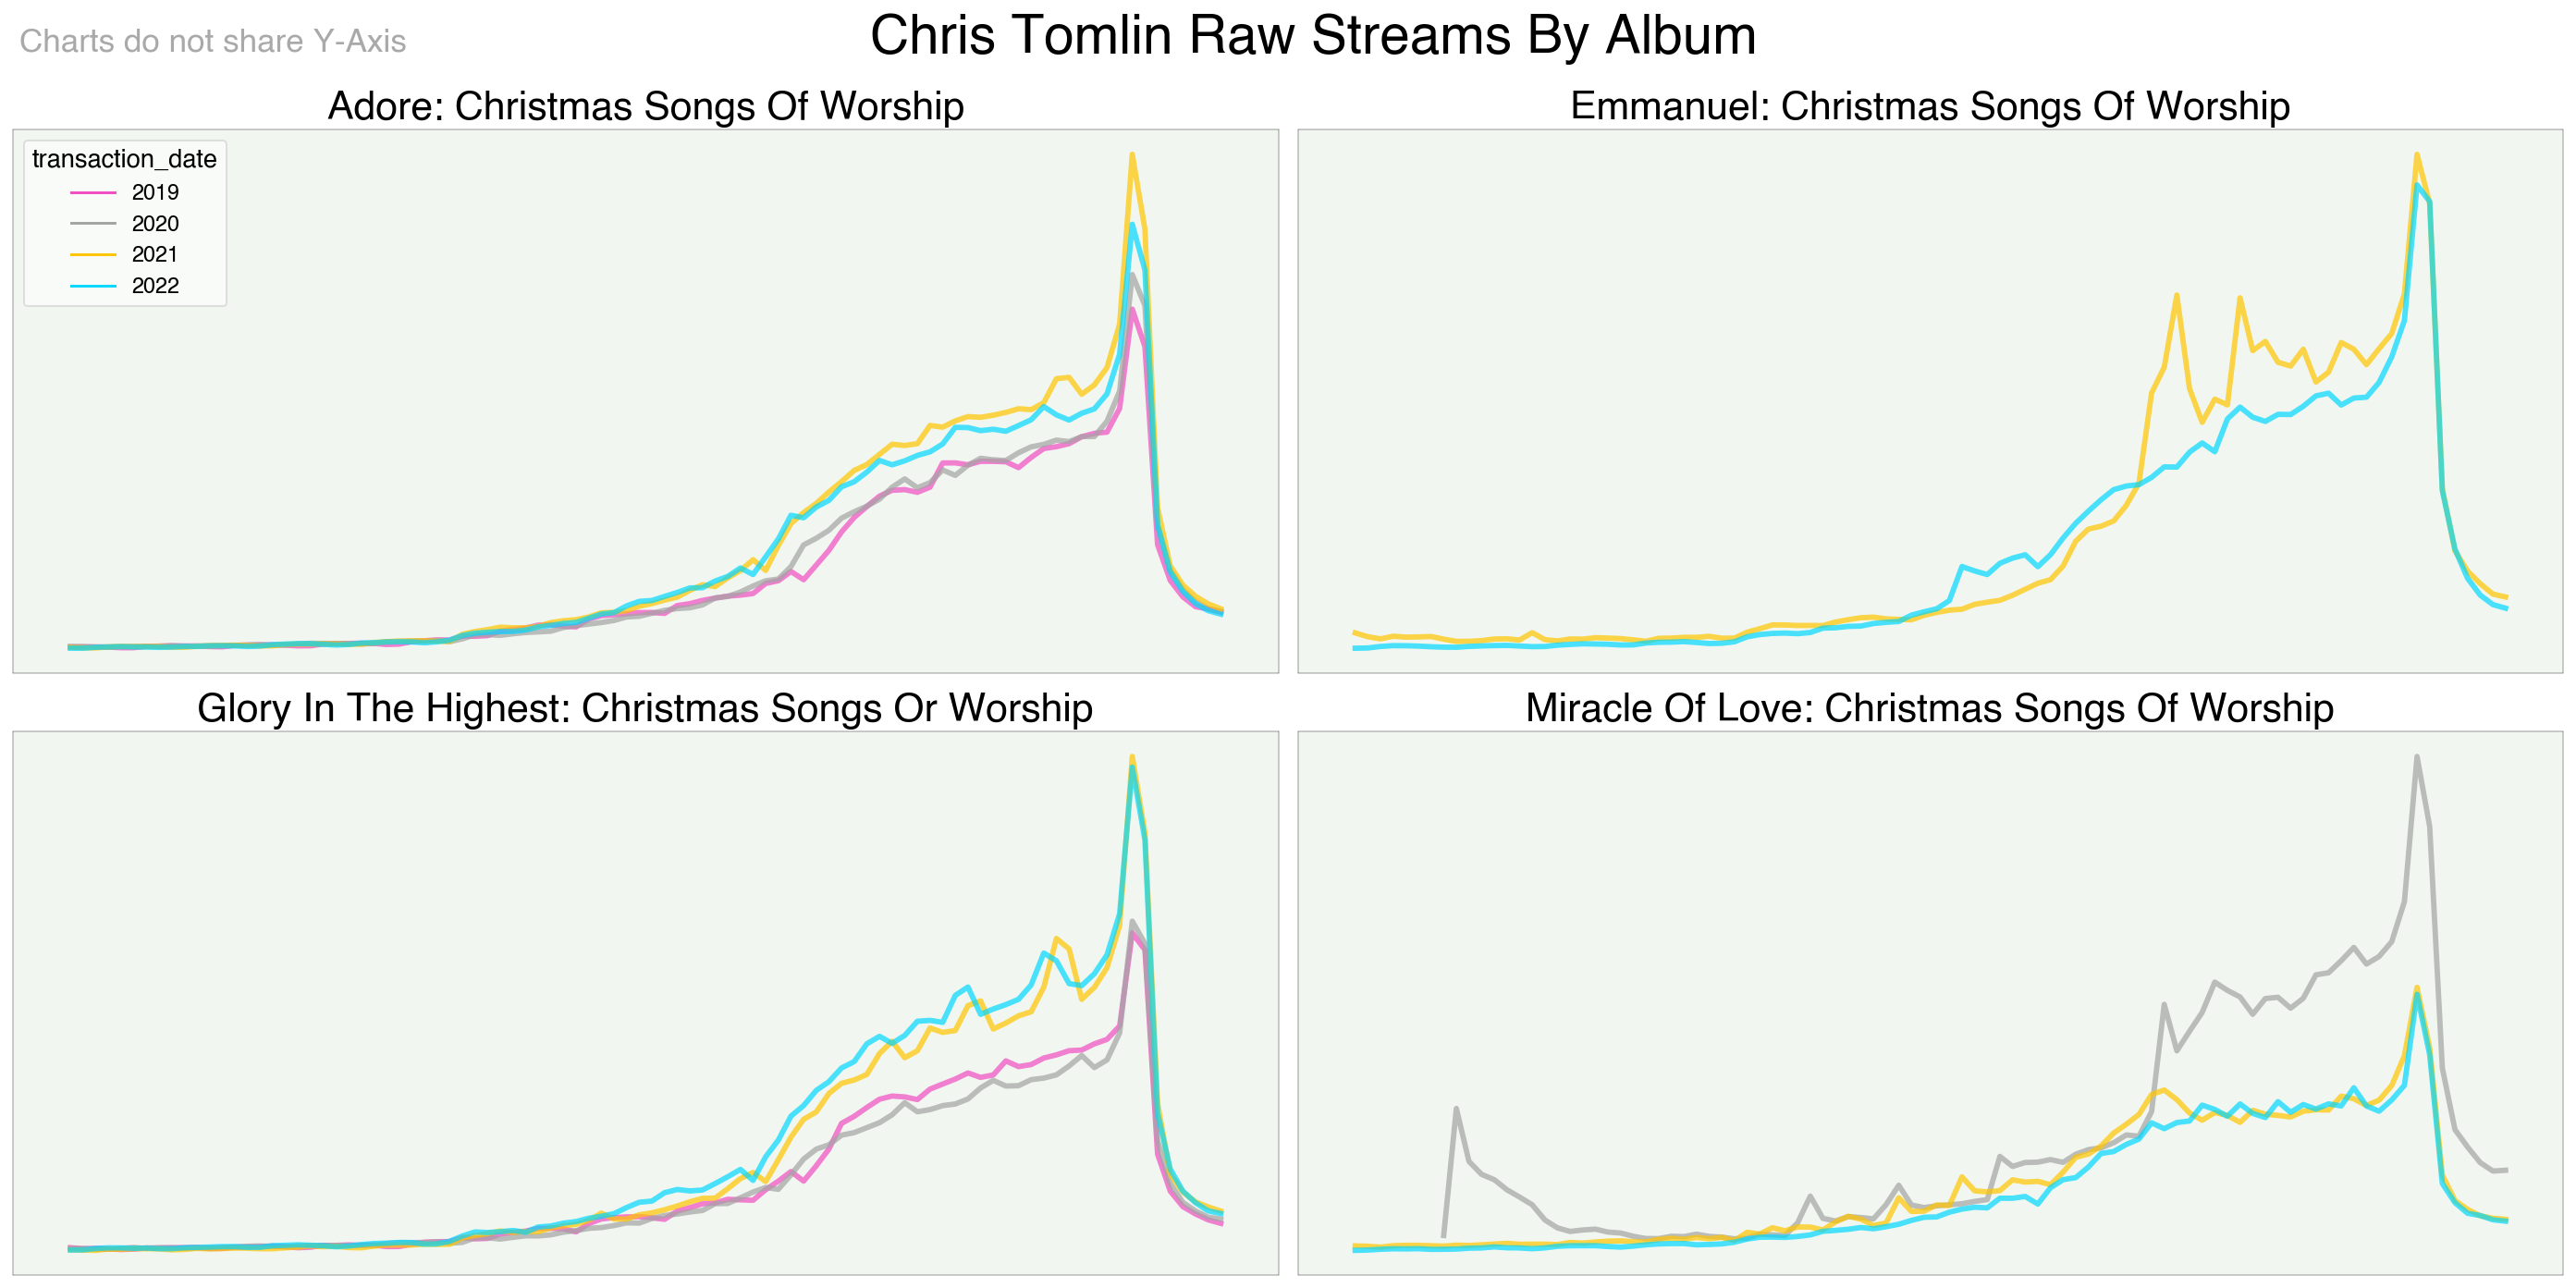

In [209]:
def plot_albums(df):

    # palette_dict = 

    artist = df.master_artist.unique()[0]
    albums = df.master_album.unique()
    album_count = len(albums)

    fig, axes = plt.subplots(nrows=2,ncols=2,figsize = (20,10), dpi=140, sharex=True, sharey=False)

    title_string = f'{artist} Raw Streams By Album'
    out_path_image_1 = './outputs/' + title_string.lower().replace(' ', '_') + '.png'

    album_groups = df.groupby('master_album')
    group_keys = list(album_groups.groups.keys())

    for i, (ax, grp_name ) in enumerate(list(zip(axes.flatten(), group_keys))):
        df_grp = album_groups.get_group(grp_name)
        df_grp = df_grp.groupby(['transaction_date', 'month_day']).raw_stream_units.sum().reset_index().sort_values('transaction_date')

        sns.lineplot(
            data=df_grp, 
            ax=ax,
            x=df_grp['month_day'],
            y=df_grp['raw_stream_units'].div(1000000),
            hue=df_grp["transaction_date"].dt.year,
            ci=None,
            palette = {i[0]: i[1] for i in list(zip(years_list, sns.color_palette('bright').as_hex()[-4:]))},
            lw=3,
            alpha=.7,
            # legend='brief'
        ).set(
            xlabel = None,
            ylabel = None,
            title = grp_name,
            
        )

        ax.legend(borderaxespad=1, title='')

        # spine charts all the way around
        sns.despine(left=False, top=False, right=False)
  
        for i_spine in ax.spines:
            ax.spines[i_spine].set_linewidth(.2)  

        # print(i)
        # remove all but top left legend
        if i != 0:
            ax.get_legend().remove()

        # Remove Clustered Axis Labels
        for label in ax.xaxis.get_ticklabels():
            if not ("15" in label.get_text() or  "30" in label.get_text()):
                label.set_visible(False)
            else:
                print(label.get_text())

        ax.set_facecolor('#f1f7f0')
        ax.tick_params(left = False, right = False , labelleft = False ,
            labelbottom = False, bottom = False)
    

    fig.text(x=0.01, y=.96, s =f'Charts do not share Y-Axis',).set(style='italic', fontsize=18, color='darkgray')
    fig.suptitle(title_string, size = 30, weight="bold", y=0.99, x=0.51)
    plt.tight_layout()
    fig.savefig(out_path_image_1)

    return out_path_image_1

out_path_image_2 = plot_albums(df)

# plot_albums(df)

In [223]:
def rename_index_names(df):
    df.index.names = [name.replace('_', ' ').upper() for name in df.index.names]
    df.columns.names = [name.replace('_', ' ').upper() for name in df.columns.names]
    return df

def style_neg_pos_pct(v):
    if v > 0:
        color_value = 'green'
    elif v < 0:
        color_value = 'red'
    else:
        color_value = 'white'

    return f'color: {color_value}'

def style_neg_pos_int(v):
    if v == 0:
        color_value = 'white'
    else:
        color_value = 'black'

    return f'color: {color_value}'

percent_mapper = {col: '{:.0%}'.format for col in df.columns }

int_mapper = {col: '{:,f}'.format for col in df.columns }


In [218]:
def percent_change_by_year(df, group_by):
    df_list = []
    grps = df.groupby(['master_album'])

    df = (
        df.pivot_table(
            index=['master_album', group_by], 
            columns= 'year', 
            values='raw_stream_units', 
            aggfunc='sum',
            )
        .fillna(0)
        .astype(int)
        )

    if group_by == 'country':
        grps = df.groupby(['master_album'])
        for grp in grps.groups.keys():
            df_grp = grps.get_group(grp)
            df_grp.loc[(grp, 'Subtotal'), :] = df_grp.sum()
            df_list.append(df_grp)

        df = pd.concat(df_list)
        df.loc[('', 'GrandTotal'), :] = df.sum()

    

    df = df.T.pct_change().replace([np.nan, np.inf, -np.inf], 0).T

    df = rename_index_names(df)

    # display(df)

    return df.style.format('{:,.1%}').applymap(style_neg_pos_pct)


df_pct_change_account = percent_change_by_year(df, group_by='account')
df_pct_change_country = percent_change_by_year(df, group_by='country')


In [228]:
def consumption_table(df):
    df = df.pivot_table(index='master_album', columns='year', values='album_adjusted_units', aggfunc='sum')
    df['Total Consumption'] = df.sum(1)
    df = df.sort_values('Total Consumption', ascending=False)
    df.loc['Total Consumption'] = df.sum(0)
    df = df.fillna(0).astype(int)
    df = rename_index_names(df)

    return df.style.format('{:,}').applymap(style_neg_pos_int)

df_consumption = consumption_table(df)


In [229]:
def create_image_tag_data(image_path):

    image_bytes = open(str(image_path), 'rb').read()
    data_uri = base64.b64encode(image_bytes).decode('utf-8')
    img_tag = '<img style="margin-top: 80px;" src="data:image/png;base64,{0}">'.format(data_uri)

    return img_tag


# Greetings,

# Here is first iteration of this type of report. Take a quick glance and see if all looks good. Attached are the HTML report for PC viewing and underlying excel file data. Let me know if you want it aggregated differently as the total amount of data is huge(260mb).

# Next steps: 
# -	going to get a track level analysis in here(top tracks stream movements through time)
# -	possibly color year columns in tables to align with line chart colors so as to easily consume



In [241]:
# data_uri_1 = base64.b64encode(open(str(out_path_image_1), 'rb').read()).decode('utf-8')
# img_tag_1 = '<img style="margin-top: 80px;" src="data:image/png;base64,{0}">'.format(data_uri_1)

# data_uri_2 = base64.b64encode(open(str(out_path_image_2), 'rb').read()).decode('utf-8')
# img_tag_2 = '<img style="margin-top: 80px;" src="data:image/png;base64,{0}">'.format(data_uri_2)


html_string = '''
<html>
<head>
<meta name="viewport" content="width=device-width, initial-scale=0.5" /> 
<style> 
  #centered {{clear:both; margin: auto; zoom: 75%;}}
  html {{font-family:helvetica; margin: auto; margin-bottom: 100px; margin-bottom: 100px;}}
  png {{margin-top: 80px; margin-bottom: 80px;}}
  tables1, tables2, tables3 {{ display: inline-block; padding: 5px; border-collapse: collapse;}}

  h3 {{ font-size: 30pt; text-align:left; font-weight: normal;}}
  thead {{
    font-size: 20pt; font-weight: normal; text-align:left; vertical-align: bottom; padding: 5px; border-bottom:1px solid black; color: black; background-color: #fafaf0;
    }}
  th {{
    font-size: 20pt; font-weight: normal; text-align:left; vertical-align: bottom; padding: 5px; border-bottom:1px solid black; color: black; background-color: #f1f7f0; 
    padding-left: 100px;
    }}
  td {{
    font-size: 15pt; text-align:right; vertical-align: center; padding: 10px; border-bottom:1px solid black; background-color: white;
    padding-left: 100px; margin: 0; font-weight: normal;
    }}

    .blank, level0, level1 {{background-color: #ffffff;}}
    


    
</style>
</head>
  <body id="centered">
    <center><png>{image_1}</png></center>
  <hr>  
    <center><png>{image_2}</png></center>
  <hr>
  <center>
    <tables1 style="margin-top: 20px;">
    <center><h3>Streams Pct +/- By Account</h3></center>
    <center>{table1}</center>
    </tables1>
    <tables2 style="margin-top: 20px;">
    <center><h3>Streams Pct +/- By Country</h3></center>
    <center>{table2}</center>
    </tables2>
    <tables3 style="margin-top: 20px;">
    <center><h3>Total Consumption</h3></center>
    <center>{table3}</center>
    </tables3>

  </center>
  </body>
</html>
'''.format(
        image_1=create_image_tag_data(out_path_image_1),
        image_2=create_image_tag_data(out_path_image_2),
        table1=df_pct_change_account.to_html(),
        table2=df_pct_change_country.to_html(),
        table3=df_consumption.to_html(),


        )




with open(out_path_html, 'w') as f:
    f.write(html_string)

In [231]:
# df.pivot_table(index=['master_artist', 'master_track']).agg(
#     {'year': 'first'}
# )
out_path_excel = out_path_html.replace('.html', '_data.xlsx')

df.groupby(['master_artist', 'master_album', 'master_track', 'transaction_date', 'account']).agg({'raw_stream_units': 'sum', 'album_adjusted_units': 'sum'}).reset_index().to_excel(out_path_excel)

In [216]:
from appscript import app, k
from mactypes import Alias
from pathlib import Path

def create_message_with_attachment():
    subject = f'{title_string}'
    body = f'<br>\n{html_string}' \
        .replace('padding-left: 100px', 'padding-left: 20px') \
        .replace('font-size: 20pt', 'font-size: 15pt') \
        .replace('font-size: 15pt', 'font-size: 10pt') \
        .replace('padding: 10px', 'padding: 2px') \
        .replace('<hr>', '') \
        .replace('<center>', '') \
        .replace('</center>', '') \
        .replace('font-size: 30pt;', 'font-size: 20pt;') 
    to_recip = []

    msg = Message(subject=subject, body=body, to_recip=to_recip, cc_recip=['david.sylvester@umusic.com'])

    # attach file
    e = str(out_path_excel)
    p = str(out_path_html)
    
    msg.add_attachment(e)
    msg.add_attachment(p)
    

    msg.show()

class Outlook(object):
    def __init__(self):
        self.client = app('Microsoft Outlook')

class Message(object):
    def __init__(self, parent=None, subject='', body='', to_recip=[], cc_recip=[], show_=True):

        if parent is None: parent = Outlook()
        client = parent.client

        self.msg = client.make(
            new=k.outgoing_message,
            with_properties={k.subject: subject, k.content: body})

        self.add_recipients(emails=to_recip, type_='to')
        self.add_recipients(emails=cc_recip, type_='cc')

        if show_: self.show()

    def show(self):
        self.msg.open()
        self.msg.activate()

    def add_attachment(self, p):
        # p is a Path() obj, could also pass string

        p = Alias(str(p)) # convert string/path obj to POSIX/mactypes path

        attach = self.msg.make(new=k.attachment, with_properties={k.file: p})

    def add_recipients(self, emails, type_='to'):
        if not isinstance(emails, list): emails = [emails]
        for email in emails:
            self.add_recipient(email=email, type_=type_)

    def add_recipient(self, email, type_='to'):
        msg = self.msg

        if type_ == 'to':
            recipient = k.to_recipient
        elif type_ == 'cc':
            recipient = k.cc_recipient

        msg.make(new=recipient, with_properties={k.email_address: {k.address: email}})

In [188]:
create_message_with_attachment()

In [ ]:
## TABLE 1 (RAW STREAM)
def raw_stream_units_table(df):
    df = df[df['usage_group'].str.contains('Streaming')]
    df_list = []
    sub_totals = []
    album_groups = df.groupby(['master_album'])
    for grp in album_groups.groups.keys():

        df1 = album_groups.get_group(grp)
        df2 = df1.pivot_table(index=['master_album', 'master_track'], columns=['account'], values='raw_stream_units', aggfunc='sum')
        df2['TOTAL'] = df2.sum(1)
        df2 = df2.sort_values(['master_album', 'TOTAL'], ascending=False, axis=0)
        grp_subtotal = df2.sum()
        df2.loc[(grp, f'SUB TOTAL'), :] = grp_subtotal
        df_list.append(df2)
        sub_totals.append(grp_subtotal)

    final_df = pd.concat(df_list, axis=0).fillna(0)
    final_df.loc[('ALL ALBUM', 'GRAND TOTAL'), :] = sum(sub_totals)
    reset_df = final_df.reset_index()
    return final_df.astype(int), reset_df[reset_df['master_track'].str.contains('TOTAL')].index



## TABLE 2 (TRACK DOWNLOADS)
def track_download_table(df):
    df = df[df['usage_group'].str.contains('Track')]
    df_list = []
    sub_totals = []
    # total_indexes = []
    album_groups = df.groupby(['master_album'])
    for grp in album_groups.groups.keys():

        df1 = album_groups.get_group(grp)
        df2 = df1.pivot_table(index=['master_album', 'master_track'], columns=['account'], values='units', aggfunc='sum')
        # display(df2.head())
        df2['TOTAL'] = df2.sum(1)
        df2 = df2.sort_values(['master_album', 'TOTAL'], ascending=False, axis=0)
        grp_subtotal = df2.sum()
        df2.loc[(grp, f'SUB TOTAL'), :] = grp_subtotal
        # display(df2.head())
        df_list.append(df2)
        sub_totals.append(grp_subtotal)

    final_df = pd.concat(df_list, axis=0).fillna(0)
    final_df.loc[('ALL ALBUM', 'GRAND TOTAL'), :] = sum(sub_totals)
    reset_df = final_df.reset_index()

    return final_df.fillna(0).astype(int), reset_df[reset_df['master_track'].str.contains('TOTAL')].index

## TABLE 3 (TOTAL CONSUMPTION)
def total_consumption_table(df):
    # df2 = df1.pivot_table(index=['master_album', 'master_track'], columns=['account'], values='units', aggfunc='sum')
    df1 = df.pivot_table(index=['master_album'], values='album_adjusted_units', aggfunc='sum')

    df1 = df1.sort_values('album_adjusted_units', ascending=False)
    df1.loc['GRAND TOTAL', :] = df1.sum(0)

    print(df1.shape)

    return df1.astype(int)

# df_raw_streams, df_raw_streams_indexes = raw_stream_units_table(df)

# df_track_downloads, df_track_downloads_indexes = track_download_table(df)

# df_total_consumption = total_consumption_table(df)